In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Nexullance_IT import Nexullance_IT
from Nexullance_MP import Nexullance_MP
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from topologies.RRG import RRGtopo
import globals as gl
import copy
from joblib import Parallel, delayed
%matplotlib widget

# setup network, not yet using nexullance

In [2]:
config=(36, 5)
EPR=3
_network = RRGtopo(config[0], config[1])
Cap_remote = 10 #GBps
Cap_local = 10 #GBps
M_EPs = gl.generate_uniform_traffic_pattern(config[0], EPR) # an numpy matrix filled with ones
M_R = gl.convert_M_EPs_to_M_R(M_EPs, config[0], EPR)

In [3]:
ASP, _ = _network.calculate_all_shortest_paths()
ECMP_ASP = gl.ECMP(ASP)
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EPs)
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
max_local_link_load = np.max(local_link_flows)/Cap_local

# adapt the traffic scaling factor to 10x saturation
traffic_scaling = 10.0/max(max_local_link_load, max_remote_link_load)
M_EPs = traffic_scaling * M_EPs
M_R = gl.convert_M_EPs_to_M_R(M_EPs, config[0], EPR)
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EPs)
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
max_local_link_load = np.max(local_link_flows)/Cap_local

print("Max remote link load: ", max_remote_link_load)
print("Max local link load: ", max_local_link_load)
if max_remote_link_load > 1.0 or max_local_link_load > 1.0:
    print("network congestion may present")
    mu = max_local_link_load/max_remote_link_load
    if mu > 1.0:
        print(f"mu = {mu} > 1, max local link load is higher")
    else:
        print(f"mu = {mu} < 1, max remote link load is higher")
else:
    print("network is probably not congested")
print("network_total_throughput = ", gl.network_total_throughput(M_EPs, max_remote_link_load, max_local_link_load), "GBps")

Max remote link load:  10.00000000000001
Max local link load:  5.157351607608161
network congestion may present
mu = 0.5157351607608156 < 1, max remote link load is higher
network_total_throughput =  556.9939736216808 GBps


In [4]:
# apply simple ECMP_MP_APST4:
MP_APST4 = _network.calculate_all_paths_within_length(4)
nexu = Nexullance_MP(_network.nx_graph, MP_APST4, M_R, Cap_remote, 0, False)
nexu.init_model()
Lremote_NEXU_MP_MP_APST4, _ = nexu.solve()
OPTIMUM = gl.network_total_throughput(M_EPs, Lremote_NEXU_MP_MP_APST4, max_local_link_load)
print(f"OPTIMUM is:{OPTIMUM}")

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
OPTIMUM is:750.3896103896108


# start to sweep parameters

In [5]:
# initialize data
_alphas = np.array(list(range(0, 20, 2)), dtype=float)
_alphas[0]+=0.1
_betas = np.array(list(np.arange(0.0, 4.0, 0.4)), dtype=float)

num_method_1 = 4
_result_Phis = np.ndarray((num_method_1, len(_alphas), len(_betas)), dtype=float)*0 
# the first dimension corresponds to iterations


In [6]:
nexu_it = Nexullance_IT(_network.nx_graph, M_R, Cap_remote)

In [7]:
# Function to be executed in parallel
def parallel_method(alpha, beta):
    nexu_it_test = copy.deepcopy(nexu_it)
    def weighted_method(s: int, d: int, edge_attributes: dict):
        return method_1_weights(s, d, edge_attributes, alpha, beta)
    result_list, _ = nexu_it_test.optimize(num_method_1, 0, weighted_method, None)
    print(f"calculation done for alpha={alpha}, beta={beta}")
    return [gl.network_total_throughput(M_EPs, result_list[it], max_local_link_load) for it in range(num_method_1)]

# Function to calculate method_1_weights
def method_1_weights(s: int, d: int, edge_attributes: dict, alpha: float, beta: float):
    return alpha + edge_attributes['load']**beta

# Parallel computation
results = Parallel(n_jobs=10)(
    delayed(parallel_method)(alpha, beta) for alpha in _alphas for beta in _betas
)

# Process the results
for i, _alpha in enumerate(_alphas):
    for j, _beta in enumerate(_betas):
        for it in range(num_method_1):
            _result_Phis[it, i, j] = results[i * len(_betas) + j][it]
        #TODO: validate the matching of data 

calculation done for alpha=0.1, beta=0.0
calculation done for alpha=0.1, beta=2.0
calculation done for alpha=0.1, beta=0.8
calculation done for alpha=0.1, beta=1.2000000000000002
calculation done for alpha=0.1, beta=0.4
calculation done for alpha=0.1, beta=1.6
calculation done for alpha=0.1, beta=3.2
calculation done for alpha=0.1, beta=2.8000000000000003
calculation done for alpha=0.1, beta=2.4000000000000004
calculation done for alpha=0.1, beta=3.6
calculation done for alpha=2.0, beta=0.4
calculation done for alpha=2.0, beta=0.0
calculation done for alpha=2.0, beta=1.2000000000000002
calculation done for alpha=2.0, beta=0.8
calculation done for alpha=4.0, beta=0.0
calculation done for alpha=2.0, beta=2.8000000000000003
calculation done for alpha=2.0, beta=2.0
calculation done for alpha=4.0, beta=0.4
calculation done for alpha=2.0, beta=1.6
calculation done for alpha=2.0, beta=3.6
calculation done for alpha=4.0, beta=0.8
calculation done for alpha=2.0, beta=3.2
calculation done for al

In [8]:
_result_Phis

array([[[556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362],
        [556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362],
        [556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362],
        [556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362],
        [556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362],
        [556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.99397362, 556.99397362, 556.99397362,
         556.99397362, 556.993

# plot

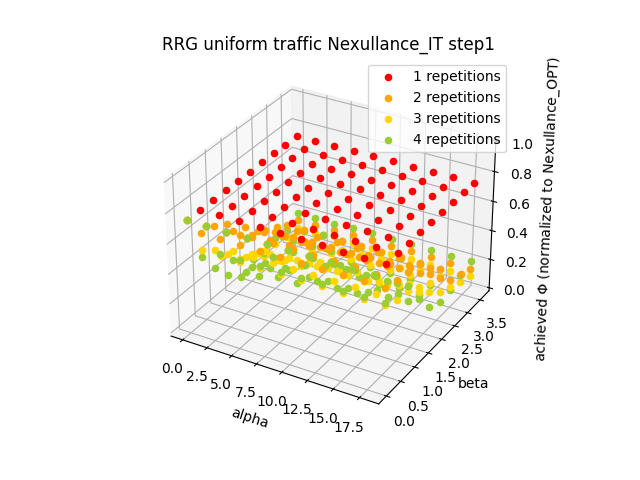

In [9]:
colors = ['red', 'orange', 'gold', 'yellowgreen']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

legend_handles = []  # List to store legend handles
legend_labels = []   # List to store legend labels

for i, _alpha in enumerate(_alphas):
    for j, _beta in enumerate(_betas):
        for it in range(num_method_1):
            # Scatter plot
            ax.scatter(_alpha, _beta, _result_Phis[it, i, j] / OPTIMUM,
                       marker='o', c=colors[it])

# Create legend handles and labels for each color
for it, color in enumerate(colors):
    legend_handles.append(ax.scatter([], [], [], c=color, label=f"{it+1} times"))
    legend_labels.append(f"{it+1} repetitions")

ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('achieved $\Phi$ (normalized to Nexullance_OPT)')
ax.set_zlim([0, 1])
ax.set_title('RRG uniform traffic Nexullance_IT step1')

# Plot legend with the handles and labels created
plt.legend(handles=legend_handles, labels=legend_labels)
plt.show()


In [10]:
np.max(_result_Phis)/ OPTIMUM

0.7422730351136969

In [11]:
arg = np.argmax(_result_Phis)
arg_rep = arg//100
arg_alpha = (arg%100)//10
arg_beta = arg%10

print("The optimal representation is: ", arg_rep)
print("The optimal alpha is: ", _alphas[arg_alpha])
print("The optimal beta is: ", _betas[arg_beta])

The optimal representation is:  0
The optimal alpha is:  0.1
The optimal beta is:  0.0
